In [171]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
import random 
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

# from keras.models import Sequential
# from keras.layers import Dense, Activation
# from keras.datasets import mnist
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mutual_info_score, r2_score
# from qiskit.circuit.library.standard_gates import RYGate, RYYGate
# import cv2

In [172]:
def hadamard(circ, n):
  for i in n:
    circ.h(i)

In [173]:
# This function let us know which are the qubits that need to be applied  
# the X-gate so we can change the state of the pixels positions qubits
# to the new state.
def change(state, new_state):
  n = len(state)  # n is the length of the binary string
  c = np.array([])  # create an empty array
  for i in range(n):  # start to iterate n times
    if state[i] != new_state[i]:  # here we check if the position i in the 
                                  # binary string is different
      c = np.append(c, int(i))

  if len(c) > 0:
    return c.astype(int)
  else:
    return c

In [174]:
# This function applies the X-gates to the corresponding qubits given by 
# the change function
def binary(circ, state, new_state):
  # state is the string in binary format that tells us the actual state of the pixels
  # state = '000000'
  c = change(state, new_state)
  if len(c) > 0:
    # Modified section. Added the -1 and the np.abs
    circ.x(np.abs(c-5))
  else: 
    pass

In [175]:
# This function applies the C^n(Ry) (controlled Ry gate) in the quantum circuit
# "circ" using the vector "n" for the controlled qubits and the variable "t" for
# the target qubit, and "theta" for the angle in the rotation. 
def cnri(circ, n, t, theta):
  #rq = circuit.qubits
  controls = len(n)
  cry = RYGate(2*theta).control(controls)
  aux = np.append(n, t).tolist()
  circ.append(cry, aux)

In [176]:
# The frqi function calls all of the aleady defined function to fully implement
# The FRQI method over the quantum circuit "circ", with the vector of controlled
# qubits "n", the target qubit "t" and the angles of each pixel in the image.
def frqi(circ,n ,t, angles):
  hadamard(circ, n)
  j = 0
  for i in angles:
    state = '{0:06b}'.format(j-1)
    new_state = '{0:06b}'.format(j)
    if j == 0:
      cnri(circ, n, t, i)
    else:
      binary(circ, state, new_state)
      cnri(circ, n, t, i)
    j += 1

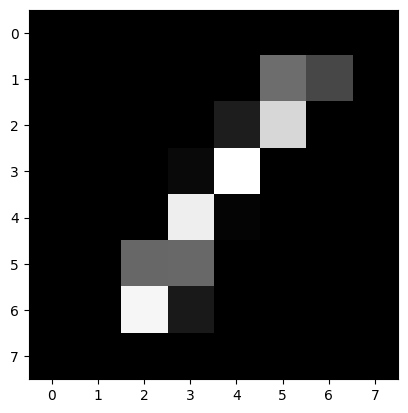

In [177]:
dataset = pd.read_csv('mnist-resized.csv')
images = dataset.to_numpy()[:,1:].reshape(42000,8,8)
pixel_values = images.reshape(42000,64)
plt.imshow(images[0,:], cmap='gray')
normalized_pixels = pixel_values/255.0
angles = np.arcsin(normalized_pixels[0,:])

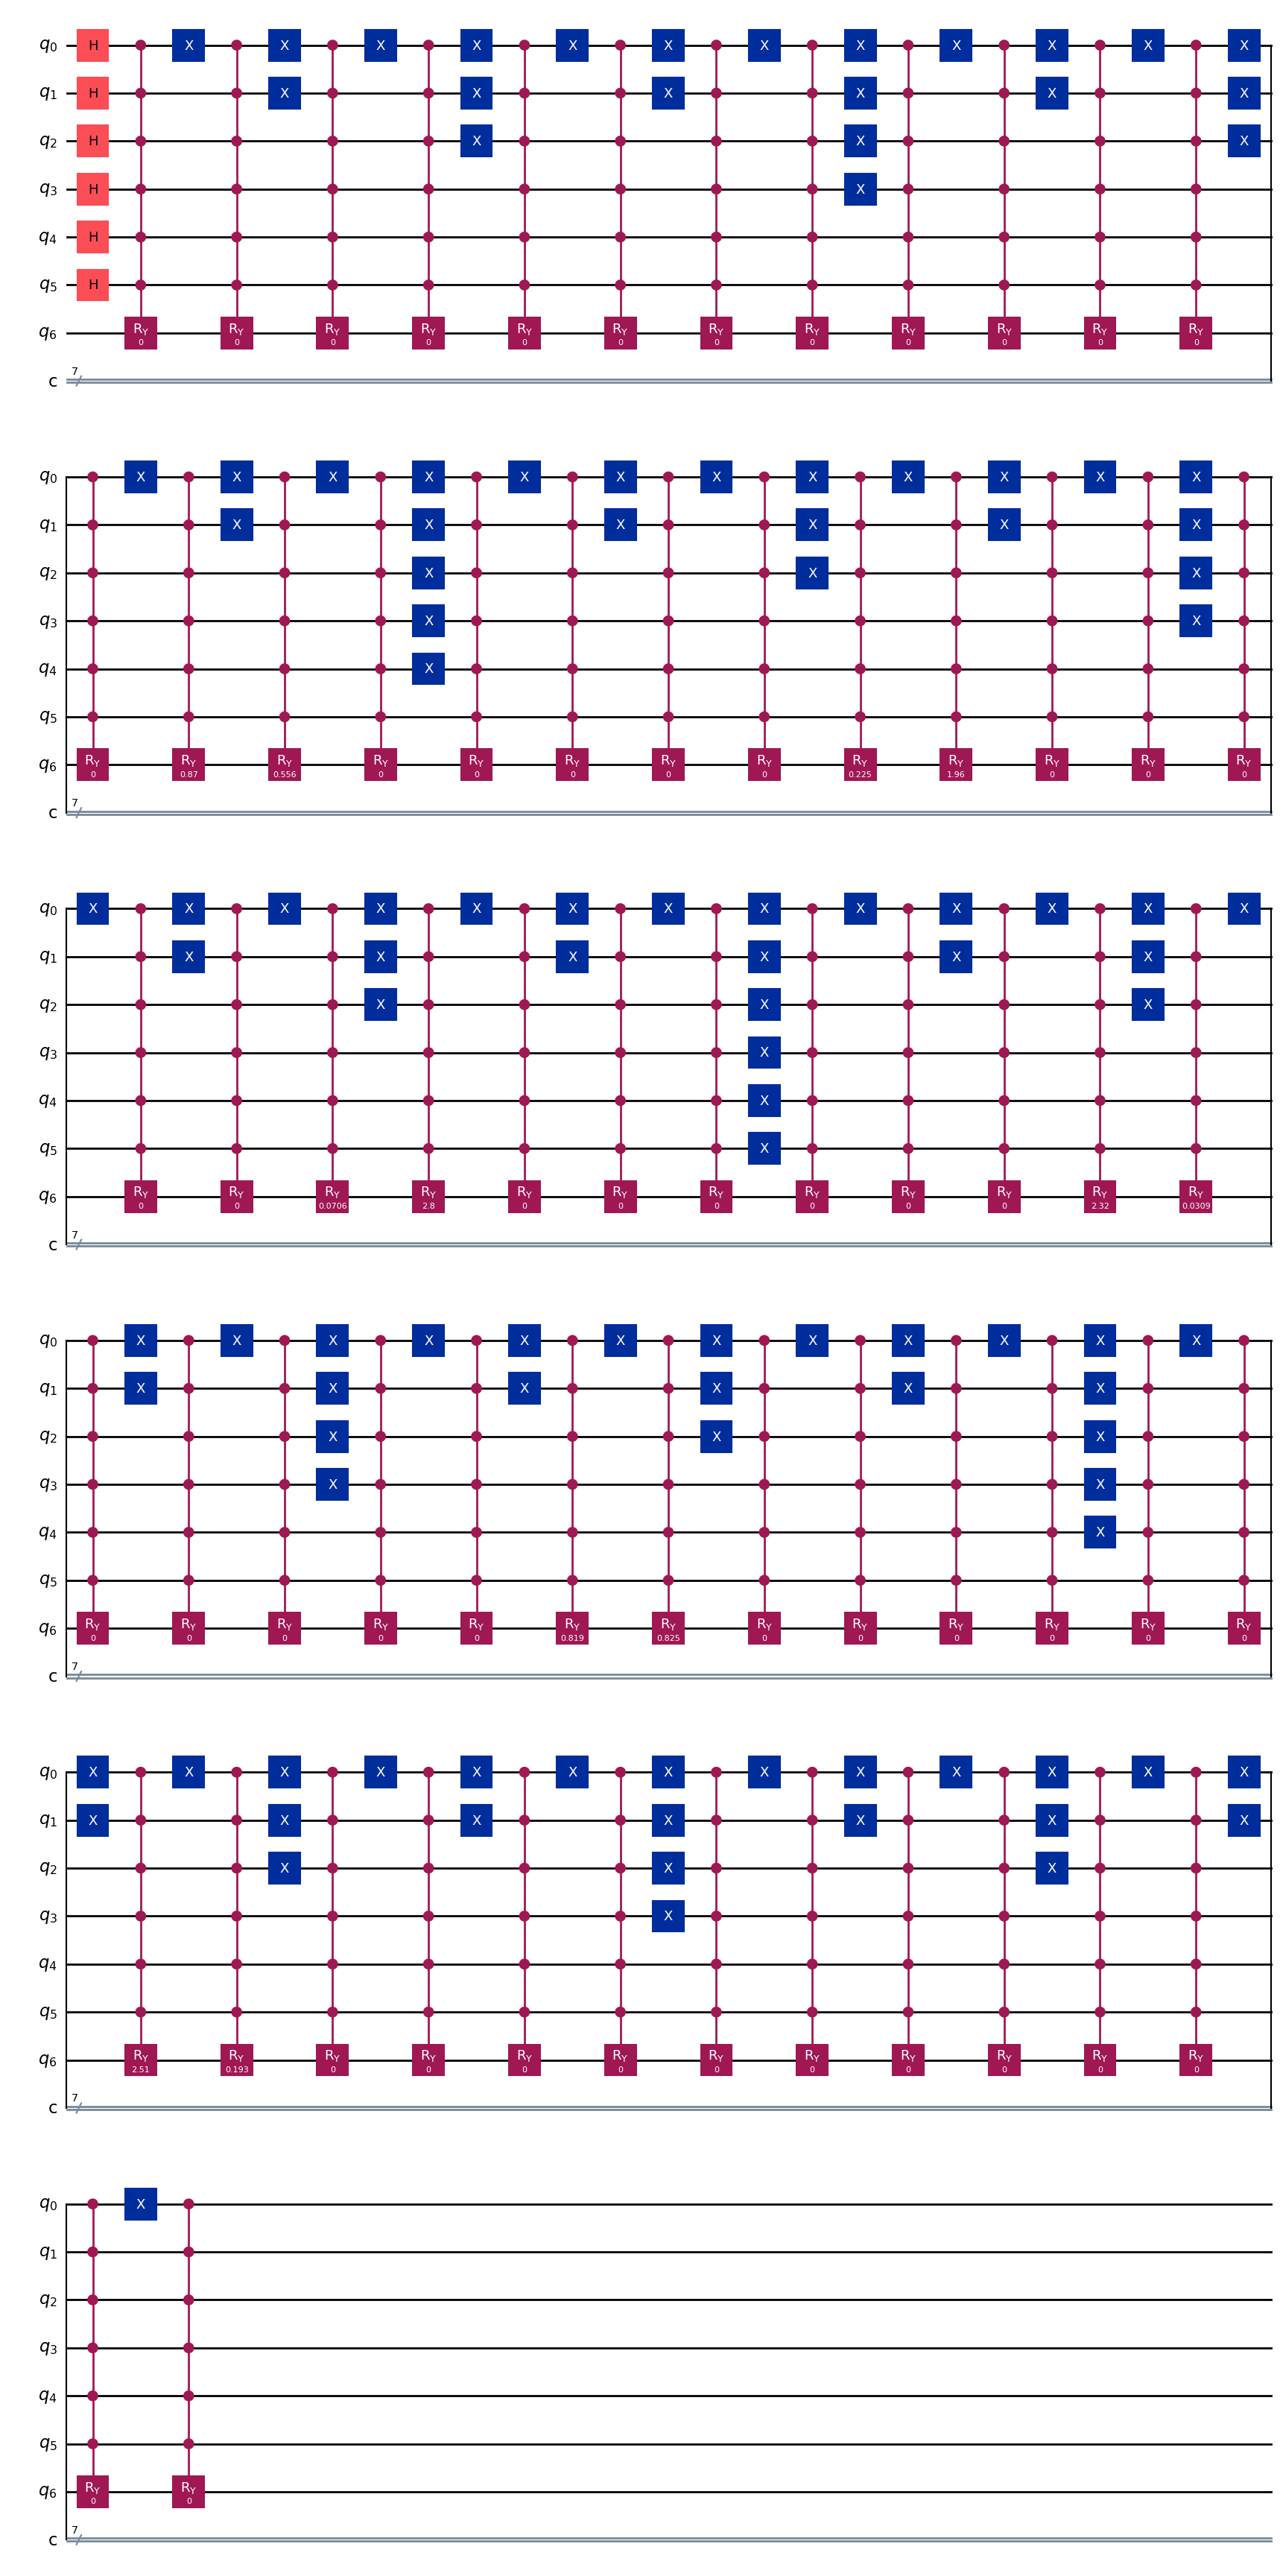

In [178]:
# Declare the Quantum and Classical registers
qr = QuantumRegister(7,'q')
cr = ClassicalRegister(7,'c')
qc = QuantumCircuit(qr,cr)
frqi(qc, [0,1,2,3,4,5], 6, angles)
qc.draw('mpl')


In [179]:
qc.measure([0,1,2,3,4,5,6],[0,1,2,3,4,5,6])

In [180]:

from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
simulator = AerSimulator()

# Transpile the circuit for the simulator
t_qc = transpile(qc, simulator)

# Run the circuit on the simulator with 128 shots
num_shots = 1000
result = simulator.run(t_qc, shots=num_shots).result()

# Get the counts (measurement outcomes)
counts = result.get_counts()

# Simplify the keys in the counts dictionary
simplified_counts = {key.split()[0]: value for key, value in counts.items()}

# Print the simplified counts
print("Simplified counts:", simplified_counts)

Simplified counts: {'1101011': 1, '1101010': 2, '0000110': 14, '0101110': 14, '0010101': 3, '1010101': 15, '1001101': 5, '0100001': 20, '0111001': 16, '0010010': 19, '0001110': 11, '0011100': 2, '0101111': 15, '0011010': 13, '0011110': 18, '0000010': 16, '0110000': 11, '0111100': 14, '0111010': 21, '0001000': 11, '0010000': 21, '0100110': 14, '0101010': 13, '0011111': 16, '0111011': 10, '0101100': 22, '0100111': 14, '1110010': 15, '0111000': 14, '0110001': 16, '0011101': 21, '0000101': 19, '0000000': 14, '0001111': 22, '0110101': 15, '0000111': 16, '0010100': 9, '0111101': 15, '0100011': 3, '0010001': 8, '0010111': 12, '0010110': 12, '0101001': 18, '0000011': 18, '0110110': 14, '0100100': 15, '0011000': 10, '0001001': 14, '0001011': 20, '0011011': 15, '1011100': 20, '0110011': 17, '0101101': 20, '0010011': 20, '0001101': 16, '0100000': 15, '0111110': 18, '0100010': 14, '0110010': 3, '0101011': 14, '0001010': 19, '0001100': 13, '0101000': 11, '0110111': 12, '0011001': 18, '1100011': 13,

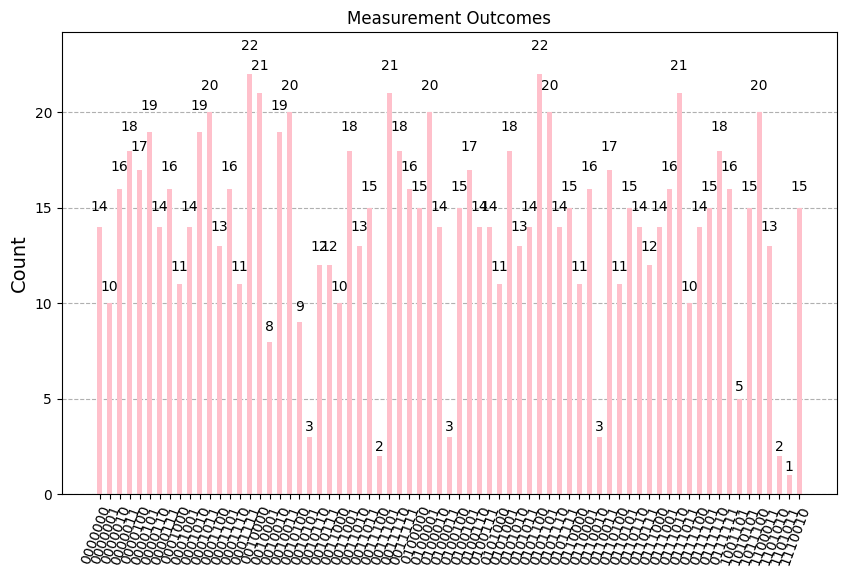

In [181]:
# Plot the histogram of results
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axes
plot_histogram(simplified_counts, title="Measurement Outcomes", bar_labels=True, ax=ax, color="pink")  # Pass the axes to plot_histogram
plt.show()

In [182]:

# Create an empty array to save the retrieved image
retrieve_image = np.array([])

In [183]:
# We iterate over all the pixels and obtain the proability results for each one of them
# Notice that we compute the ratio of the white states, and only if the values are 0
# we make an exception and turn that pixel 0
for i in range(64):
  try:
    s = format(i, '06b')
    new_s = '1' + s
    retrieve_image = np.append(retrieve_image,np.sqrt(simplified_counts[new_s]/num_shots))
    
  except KeyError:
    retrieve_image = np.append(retrieve_image,[0.0])


In [184]:
# We make the inverse nomalization
retrieve_image *=  8.0*255.0

In [185]:
# Turn the array into a type int
retrieve_image = retrieve_image.astype('int')

In [186]:
# Reshape the array into a 8x8 matrix
retrieve_image = retrieve_image.reshape((8,8))

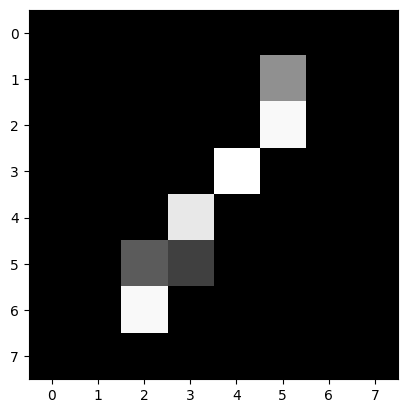

In [187]:
# Plot the retrieved image to see if it is the same as the one encoded
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.show()